# 🎯 Análise de Research Questions

## Detecção de Code Smells com Sistema Multi-Agentes LLM

**Modelo Base:** Claude Sonnet 4.5 (Anthropic)
- Input: $3.00/M tokens
- Output: $15.00/M tokens

---

### Research Questions:
- **RQ1:** Performance Geral (Multi-agentes vs Ground Truth)
- **RQ2:** Impacto da Qualidade dos Prompts
- **RQ3:** Multi-agentes vs DPy (Análise Estática)
- **RQ4:** Performance Individual dos Agentes
- **RQ5:** Eficiência Operacional


---
# 1. Carregamento de Dados


In [15]:
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

warnings.filterwarnings("ignore")

# Configurações de visualização
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12
sns.set_palette("husl")

# Paths
BASE_DIR = Path().resolve().parent
RESULTS_DIR = BASE_DIR / "results"
FIGURES_DIR = RESULTS_DIR / "figures"
DATASET_DIR = BASE_DIR / "dataset"

# Criar pasta de figuras se não existir
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Custos Claude Sonnet 4.5
INPUT_PRICE_PER_M = 3.00  # $3.00 per 1M input tokens
OUTPUT_PRICE_PER_M = 15.00  # $15.00 per 1M output tokens

print(f"📂 Base Directory: {BASE_DIR}")


📂 Base Directory: /home/luis-chaves/Área de trabalho/tcc/multi-agent-smell-detector


In [16]:
# Carregar dados
print("📊 Carregando datasets...")

# Ground Truth
gt = pd.read_csv(DATASET_DIR / "ground_truth" / "ground_truth_corrected.csv")
print(f"✅ Ground Truth: {len(gt)} entradas")

# Multi-agentes - Prompts Elaborados
ma_complete = pd.read_csv(RESULTS_DIR / "csv" / "results_with_complete_prompts.csv")
print(f"✅ Multi-agentes (Elaborados): {len(ma_complete)} detecções")

# Multi-agentes - Prompts Simples
ma_simple = pd.read_csv(RESULTS_DIR / "csv" / "results_simple_prompt.csv")
print(f"✅ Multi-agentes (Simples): {len(ma_simple)} detecções")

# DPy (Análise Estática)
dpy = pd.read_csv(RESULTS_DIR / "dpy" / "dataset_implementation_smells.csv")
print(f"✅ DPy (Estático): {len(dpy)} detecções")


# Normalizar nomes de smells
def normalize_smell(smell):
    if pd.isna(smell):
        return "unknown"
    return smell.lower().strip()


def extract_filename(path):
    if pd.isna(path):
        return ""
    return Path(str(path)).name


gt["smell_normalized"] = gt["Code_Smell"].apply(normalize_smell)
ma_complete["smell_normalized"] = ma_complete["Code_Smell"].apply(normalize_smell)
ma_simple["smell_normalized"] = ma_simple["Code_Smell"].apply(normalize_smell)
dpy["smell_normalized"] = dpy["Smell"].apply(normalize_smell)

gt["file_name"] = gt["File"].apply(extract_filename)
ma_complete["file_name"] = ma_complete["File"].apply(extract_filename)
ma_simple["file_name"] = ma_simple["File"].apply(extract_filename)
dpy["file_name"] = dpy["File"].apply(extract_filename)

print("✅ Dados normalizados!")


📊 Carregando datasets...
✅ Ground Truth: 397 entradas
✅ Multi-agentes (Elaborados): 432 detecções
✅ Multi-agentes (Simples): 919 detecções
✅ DPy (Estático): 385 detecções
✅ Dados normalizados!


In [17]:
# Função para calcular métricas
def calculate_metrics(detections_df, gt_df):
    """Calcula TP, FP, FN, Precision, Recall, F1-Score."""
    matched_gt = set()
    matched_det = set()

    for det_idx, det in detections_df.iterrows():
        for gt_idx, gt_row in gt_df.iterrows():
            if gt_idx in matched_gt:
                continue

            # Match por arquivo e smell
            if det["file_name"] != gt_row["file_name"]:
                continue
            if det["smell_normalized"] != gt_row["smell_normalized"]:
                continue

            # Match encontrado
            matched_gt.add(gt_idx)
            matched_det.add(det_idx)
            break

    tp = len(matched_det)
    fp = len(detections_df) - tp
    fn = len(gt_df) - len(matched_gt)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )

    return {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }


# Resumo dos dados
summary = pd.DataFrame(
    {
        "Dataset": [
            "Ground Truth",
            "Multi-agentes (Elaborados)",
            "Multi-agentes (Simples)",
            "DPy (Estático)",
        ],
        "Total Detecções": [len(gt), len(ma_complete), len(ma_simple), len(dpy)],
        "Arquivos Únicos": [
            gt["file_name"].nunique(),
            ma_complete["file_name"].nunique(),
            ma_simple["file_name"].nunique(),
            dpy["file_name"].nunique(),
        ],
        "Tipos de Smell": [
            gt["smell_normalized"].nunique(),
            ma_complete["smell_normalized"].nunique(),
            ma_simple["smell_normalized"].nunique(),
            dpy["smell_normalized"].nunique(),
        ],
    }
)

print("📋 Resumo dos Datasets")
display(summary)


📋 Resumo dos Datasets


,Dataset,Total Detecções,Arquivos Únicos,Tipos de Smell
0,Ground Truth,397,17,11
1,Multi-agentes (Elaborados),432,18,11
2,Multi-agentes (Simples),919,20,9
3,DPy (Estático),385,20,11


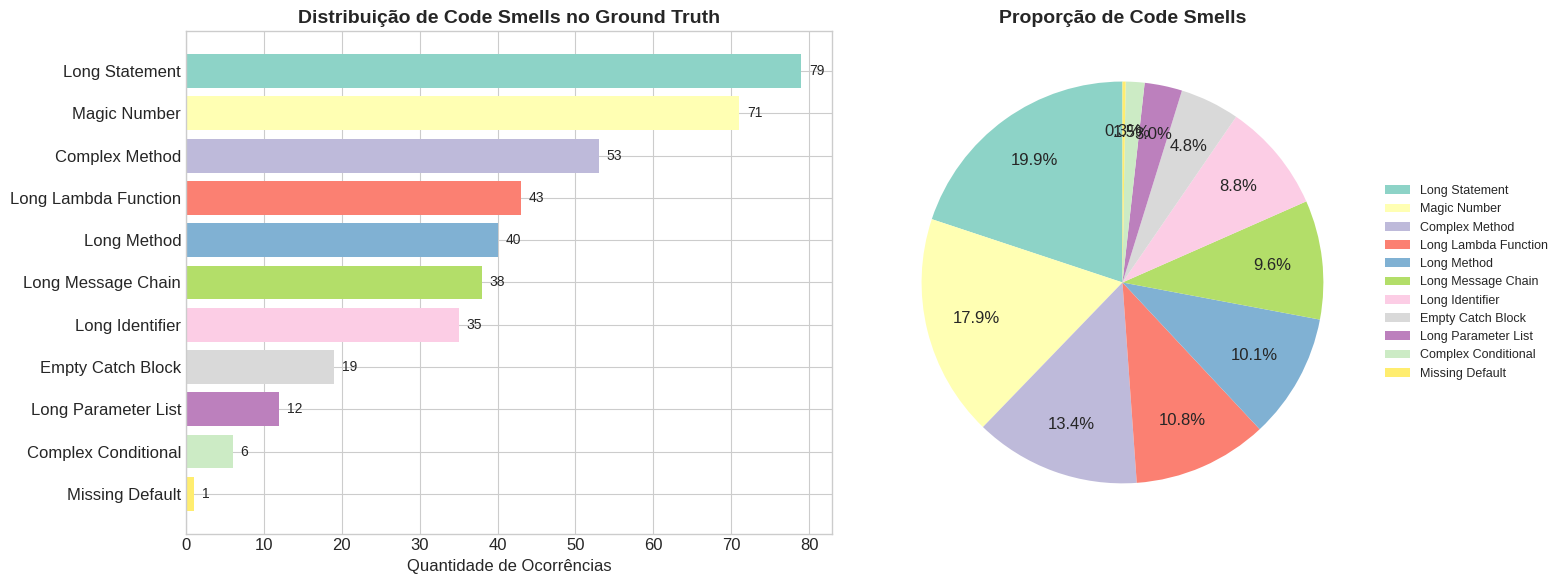

In [18]:
# Gráfico: Distribuição de Code Smells no Ground Truth
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras - Distribuição no GT
smell_counts = gt["smell_normalized"].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(smell_counts)))

ax1 = axes[0]
bars = ax1.barh(range(len(smell_counts)), smell_counts.values, color=colors)
ax1.set_yticks(range(len(smell_counts)))
ax1.set_yticklabels([s.title() for s in smell_counts.index])
ax1.set_xlabel("Quantidade de Ocorrências")
ax1.set_title(
    "Distribuição de Code Smells no Ground Truth", fontsize=14, fontweight="bold"
)
ax1.invert_yaxis()

# Adicionar valores nas barras
for bar, val in zip(bars, smell_counts.values):
    ax1.text(
        val + 1, bar.get_y() + bar.get_height() / 2, str(val), va="center", fontsize=10
    )

# Gráfico de pizza - Proporção
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    smell_counts.values,
    labels=None,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    pctdistance=0.75,
)
ax2.legend(
    [s.title() for s in smell_counts.index],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=9,
)
ax2.set_title("Proporção de Code Smells", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "distribuicao_smells_gt.png", dpi=150, bbox_inches="tight"
)
plt.show()


---
# 2. RQ1: Performance Geral (Multi-agentes vs Ground Truth)

**Pergunta:** Qual é a eficácia do sistema multi-agentes na detecção de code smells comparado ao ground truth manual?


In [19]:
# Métricas globais
print("📊 Calculando métricas...")
metrics_complete = calculate_metrics(ma_complete, gt)
metrics_simple = calculate_metrics(ma_simple, gt)
metrics_dpy = calculate_metrics(dpy, gt)

# Tabela de resultados RQ1
results_rq1 = pd.DataFrame(
    {
        "Métrica": [
            "Total Detecções",
            "True Positives",
            "False Positives",
            "False Negatives",
            "Precision",
            "Recall",
            "F1-Score",
        ],
        "Elaborados": [
            len(ma_complete),
            metrics_complete["TP"],
            metrics_complete["FP"],
            metrics_complete["FN"],
            f"{metrics_complete['Precision']:.2%}",
            f"{metrics_complete['Recall']:.2%}",
            f"{metrics_complete['F1-Score']:.2%}",
        ],
        "Simples": [
            len(ma_simple),
            metrics_simple["TP"],
            metrics_simple["FP"],
            metrics_simple["FN"],
            f"{metrics_simple['Precision']:.2%}",
            f"{metrics_simple['Recall']:.2%}",
            f"{metrics_simple['F1-Score']:.2%}",
        ],
    }
)

print("🎯 RQ1: Performance Multi-agentes vs Ground Truth")
display(results_rq1)


📊 Calculando métricas...
🎯 RQ1: Performance Multi-agentes vs Ground Truth


,Métrica,Elaborados,Simples
0,Total Detecções,432,919
1,True Positives,291,241
2,False Positives,141,678
3,False Negatives,106,156
4,Precision,67.36%,26.22%
5,Recall,73.30%,60.71%
6,F1-Score,70.21%,36.63%


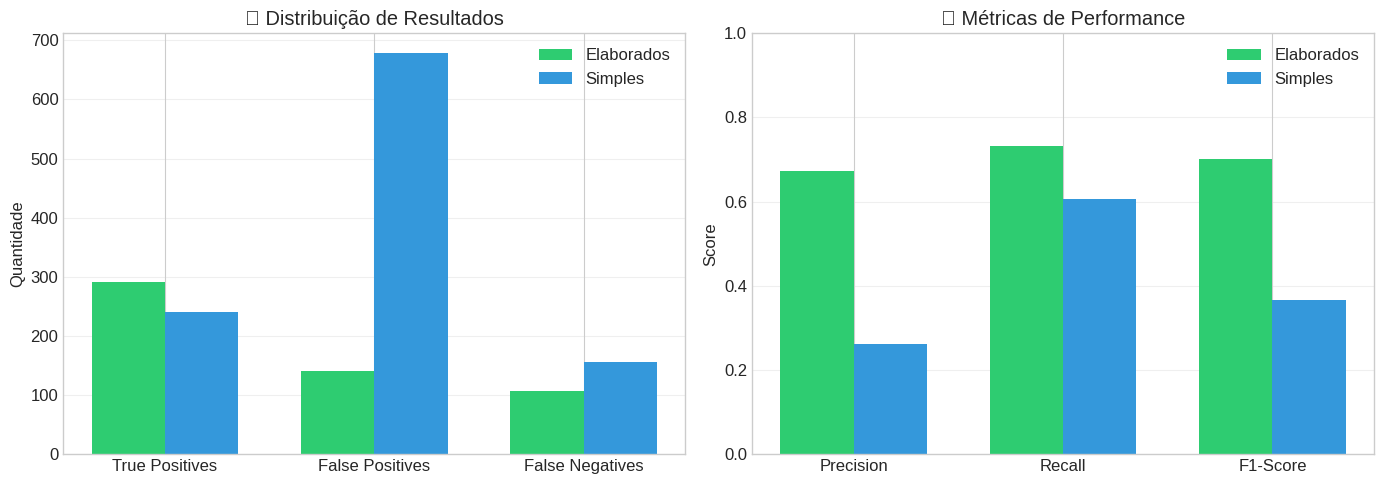

In [20]:
# Visualização RQ1 - Métricas por tipo de prompt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: TP, FP, FN
x = np.arange(3)
width = 0.35
ax1 = axes[0]
ax1.bar(
    x - width / 2,
    [metrics_complete["TP"], metrics_complete["FP"], metrics_complete["FN"]],
    width,
    label="Elaborados",
    color="#2ecc71",
)
ax1.bar(
    x + width / 2,
    [metrics_simple["TP"], metrics_simple["FP"], metrics_simple["FN"]],
    width,
    label="Simples",
    color="#3498db",
)
ax1.set_xticks(x)
ax1.set_xticklabels(["True Positives", "False Positives", "False Negatives"])
ax1.set_ylabel("Quantidade")
ax1.set_title("📊 Distribuição de Resultados")
ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# Gráfico 2: Precision, Recall, F1
ax2 = axes[1]
metrics_names = ["Precision", "Recall", "F1-Score"]
complete_values = [
    metrics_complete["Precision"],
    metrics_complete["Recall"],
    metrics_complete["F1-Score"],
]
simple_values = [
    metrics_simple["Precision"],
    metrics_simple["Recall"],
    metrics_simple["F1-Score"],
]

ax2.bar(x - width / 2, complete_values, width, label="Elaborados", color="#2ecc71")
ax2.bar(x + width / 2, simple_values, width, label="Simples", color="#3498db")
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names)
ax2.set_ylabel("Score")
ax2.set_ylim(0, 1)
ax2.set_title("📈 Métricas de Performance")
ax2.legend()
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "rq1_performance.png", dpi=150, bbox_inches="tight")
plt.show()


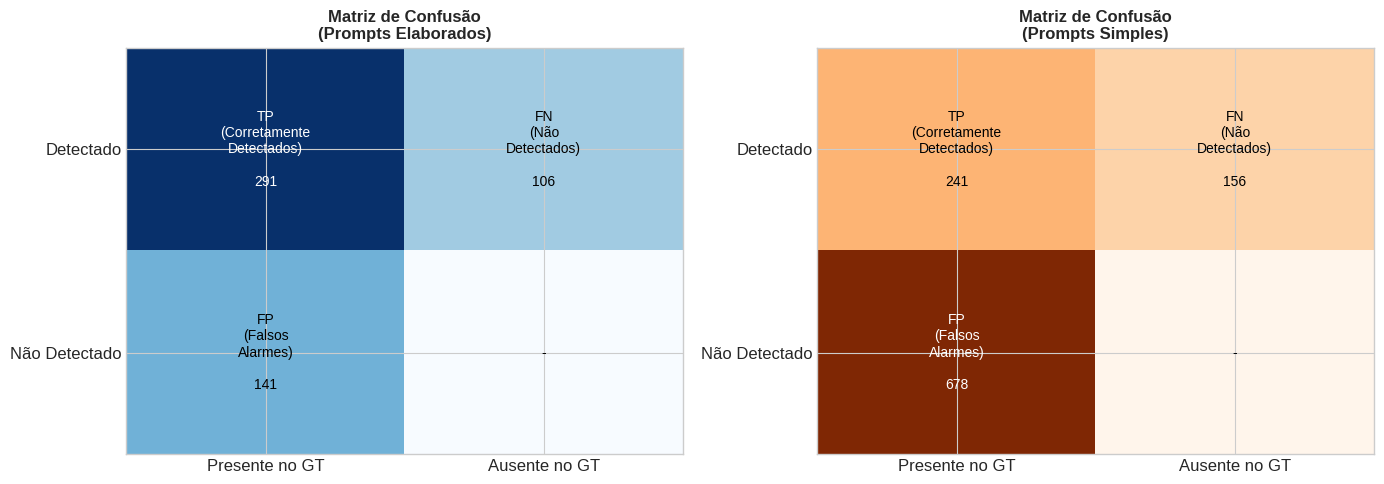

In [21]:
# Gráfico: Matriz de Confusão Visual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz para Prompts Elaborados
ax1 = axes[0]
cm_complete = np.array(
    [
        [metrics_complete["TP"], metrics_complete["FN"]],
        [metrics_complete["FP"], 0],  # TN não aplicável
    ]
)
labels_cm = [
    ["TP\n(Corretamente\nDetectados)", "FN\n(Não\nDetectados)"],
    ["FP\n(Falsos\nAlarmes)", "-"],
]

im1 = ax1.imshow(
    [[metrics_complete["TP"], metrics_complete["FN"]], [metrics_complete["FP"], 0]],
    cmap="Blues",
    aspect="auto",
)

for i in range(2):
    for j in range(2):
        val = cm_complete[i, j]
        if i == 1 and j == 1:
            text = "-"
        else:
            text = f"{labels_cm[i][j]}\n\n{val}"
        ax1.text(
            j,
            i,
            text,
            ha="center",
            va="center",
            fontsize=10,
            color="white" if val > cm_complete.max() / 2 else "black",
        )

ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(["Presente no GT", "Ausente no GT"])
ax1.set_yticklabels(["Detectado", "Não Detectado"])
ax1.set_title(
    "Matriz de Confusão\n(Prompts Elaborados)", fontsize=12, fontweight="bold"
)

# Matriz para Prompts Simples
ax2 = axes[1]
cm_simple = np.array(
    [[metrics_simple["TP"], metrics_simple["FN"]], [metrics_simple["FP"], 0]]
)
labels_cm = [
    ["TP\n(Corretamente\nDetectados)", "FN\n(Não\nDetectados)"],
    ["FP\n(Falsos\nAlarmes)", "-"],
]

im2 = ax2.imshow(
    [[metrics_simple["TP"], metrics_simple["FN"]], [metrics_simple["FP"], 0]],
    cmap="Oranges",
    aspect="auto",
)

for i in range(2):
    for j in range(2):
        val = cm_simple[i, j]
        if i == 1 and j == 1:
            text = "-"
        else:
            text = f"{labels_cm[i][j]}\n\n{val}"
        ax2.text(
            j,
            i,
            text,
            ha="center",
            va="center",
            fontsize=10,
            color="white" if val > cm_simple.max() / 2 else "black",
        )

ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(["Presente no GT", "Ausente no GT"])
ax2.set_yticklabels(["Detectado", "Não Detectado"])
ax2.set_title("Matriz de Confusão\n(Prompts Simples)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "rq1_matriz_confusao.png", dpi=150, bbox_inches="tight"
)
plt.show()


In [22]:
# RQ1 - Métricas por tipo de smell
def metrics_by_smell(detections_df, gt_df):
    smells = gt_df["smell_normalized"].unique()
    results = []

    for smell in smells:
        det_smell = detections_df[detections_df["smell_normalized"] == smell]
        gt_smell = gt_df[gt_df["smell_normalized"] == smell]

        if len(gt_smell) == 0:
            continue

        metrics = calculate_metrics(det_smell, gt_smell)
        results.append(
            {
                "Smell": smell.title(),
                "GT": len(gt_smell),
                "Detectados": len(det_smell),
                "TP": metrics["TP"],
                "Precision": metrics["Precision"],
                "Recall": metrics["Recall"],
                "F1-Score": metrics["F1-Score"],
            }
        )

    return pd.DataFrame(results)


smell_metrics = metrics_by_smell(ma_complete, gt).sort_values(
    "F1-Score", ascending=False
)

# Formatar para exibição
smell_display = smell_metrics.copy()
smell_display["Precision"] = smell_display["Precision"].apply(lambda x: f"{x:.1%}")
smell_display["Recall"] = smell_display["Recall"].apply(lambda x: f"{x:.1%}")
smell_display["F1-Score"] = smell_display["F1-Score"].apply(lambda x: f"{x:.1%}")

print("📋 RQ1: Métricas por Tipo de Smell")
display(smell_display)


📋 RQ1: Métricas por Tipo de Smell


,Smell,GT,Detectados,TP,Precision,Recall,F1-Score
9,Missing Default,1,1,1,100.0%,100.0%,100.0%
3,Long Lambda Function,43,42,42,100.0%,97.7%,98.8%
1,Complex Method,53,48,48,100.0%,90.6%,95.0%
5,Long Method,40,36,32,88.9%,80.0%,84.2%
10,Empty Catch Block,19,17,15,88.2%,78.9%,83.3%
6,Long Parameter List,12,19,12,63.2%,100.0%,77.4%
2,Long Identifier,35,50,29,58.0%,82.9%,68.2%
7,Long Statement,79,74,44,59.5%,55.7%,57.5%
4,Long Message Chain,38,53,25,47.2%,65.8%,54.9%
8,Magic Number,71,79,41,51.9%,57.7%,54.7%


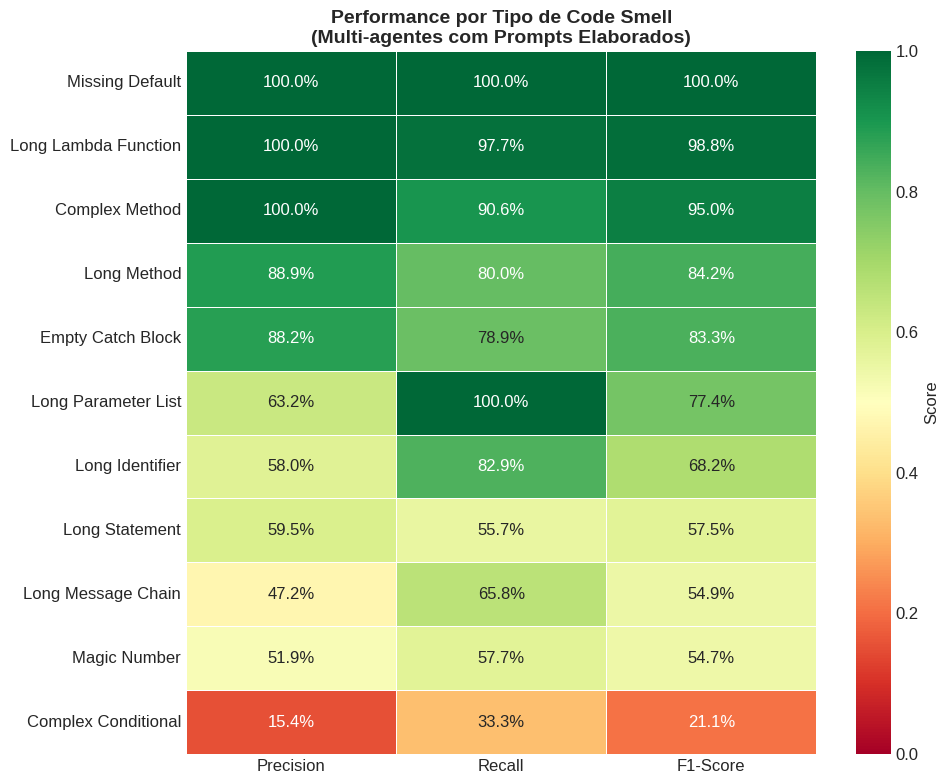

In [23]:
# Gráfico: Heatmap de Performance por Tipo de Smell
fig, ax = plt.subplots(figsize=(10, 8))

# Preparar dados para heatmap
heatmap_data = smell_metrics[["Smell", "Precision", "Recall", "F1-Score"]].set_index(
    "Smell"
)

# Criar heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1%",
    cmap="RdYlGn",
    linewidths=0.5,
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Score"},
)

ax.set_title(
    "Performance por Tipo de Code Smell\n(Multi-agentes com Prompts Elaborados)",
    fontsize=14,
    fontweight="bold",
)
ax.set_ylabel("")
ax.set_xlabel("")

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "rq1_heatmap_performance.png", dpi=150, bbox_inches="tight"
)
plt.show()


---
# 3. RQ2: Impacto da Qualidade dos Prompts

**Pergunta:** Qual é o impacto da qualidade dos prompts (elaborados vs simples) na performance de detecção?


In [24]:
# RQ2 - Comparação Elaborados vs Simples
comparison_rq2 = pd.DataFrame(
    {
        "Métrica": [
            "Total Detecções",
            "True Positives",
            "False Positives",
            "Precision",
            "Recall",
            "F1-Score",
        ],
        "Elaborados": [
            len(ma_complete),
            metrics_complete["TP"],
            metrics_complete["FP"],
            metrics_complete["Precision"],
            metrics_complete["Recall"],
            metrics_complete["F1-Score"],
        ],
        "Simples": [
            len(ma_simple),
            metrics_simple["TP"],
            metrics_simple["FP"],
            metrics_simple["Precision"],
            metrics_simple["Recall"],
            metrics_simple["F1-Score"],
        ],
    }
)

comparison_rq2["Diferença"] = comparison_rq2["Elaborados"] - comparison_rq2["Simples"]

# Teste estatístico Chi-square
contingency_table = np.array(
    [
        [metrics_complete["TP"], metrics_complete["FP"]],
        [metrics_simple["TP"], metrics_simple["FP"]],
    ]
)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("📊 RQ2: Comparação Elaborados vs Simples")
print("=" * 60)
print(
    f"\nPrecision - Elaborados: {metrics_complete['Precision']:.2%} | Simples: {metrics_simple['Precision']:.2%}"
)
print(
    f"Recall - Elaborados: {metrics_complete['Recall']:.2%} | Simples: {metrics_simple['Recall']:.2%}"
)
print(
    f"F1-Score - Elaborados: {metrics_complete['F1-Score']:.2%} | Simples: {metrics_simple['F1-Score']:.2%}"
)
print(
    f"\n📈 Diferença F1-Score: {(metrics_complete['F1-Score'] - metrics_simple['F1-Score']) * 100:+.1f} pontos percentuais"
)
print(f"\n📊 Teste Estatístico Chi-Square:")
print(f"   Chi2: {chi2:.4f} | P-value: {p_value:.4f}")
if p_value < 0.05:
    print("   ✅ Diferença ESTATISTICAMENTE SIGNIFICATIVA")
else:
    print("   ⚠️ Diferença NÃO estatisticamente significativa")


📊 RQ2: Comparação Elaborados vs Simples

Precision - Elaborados: 67.36% | Simples: 26.22%
Recall - Elaborados: 73.30% | Simples: 60.71%
F1-Score - Elaborados: 70.21% | Simples: 36.63%

📈 Diferença F1-Score: +33.6 pontos percentuais

📊 Teste Estatístico Chi-Square:
   Chi2: 206.5967 | P-value: 0.0000
   ✅ Diferença ESTATISTICAMENTE SIGNIFICATIVA


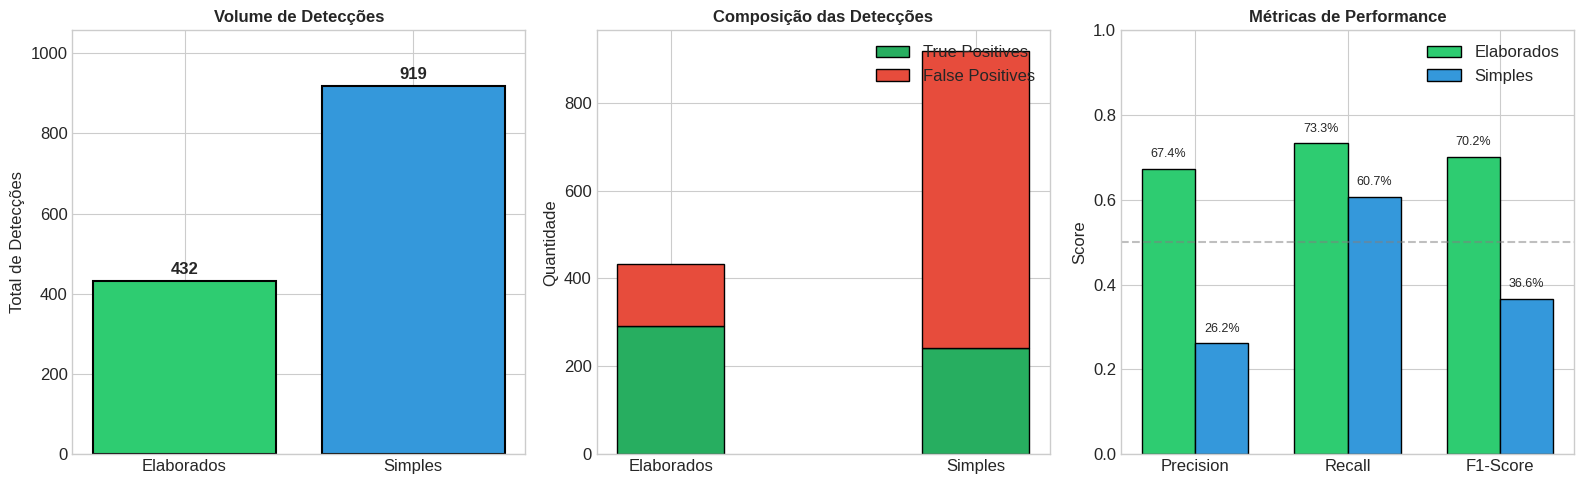

In [25]:
# Gráfico RQ2: Comparação Visual Elaborados vs Simples
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: Detecções Totais
ax1 = axes[0]
categories = ["Elaborados", "Simples"]
totals = [len(ma_complete), len(ma_simple)]
colors_bar = ["#2ecc71", "#3498db"]
bars1 = ax1.bar(categories, totals, color=colors_bar, edgecolor="black", linewidth=1.5)
ax1.set_ylabel("Total de Detecções")
ax1.set_title("Volume de Detecções", fontsize=12, fontweight="bold")
for bar, val in zip(bars1, totals):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10,
        str(val),
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )
ax1.set_ylim(0, max(totals) * 1.15)

# Gráfico 2: Composição TP vs FP
ax2 = axes[1]
x = np.arange(2)
width = 0.35
tp_vals = [metrics_complete["TP"], metrics_simple["TP"]]
fp_vals = [metrics_complete["FP"], metrics_simple["FP"]]

bars_tp = ax2.bar(
    x, tp_vals, width, label="True Positives", color="#27ae60", edgecolor="black"
)
bars_fp = ax2.bar(
    x,
    fp_vals,
    width,
    bottom=tp_vals,
    label="False Positives",
    color="#e74c3c",
    edgecolor="black",
)

ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_ylabel("Quantidade")
ax2.set_title("Composição das Detecções", fontsize=12, fontweight="bold")
ax2.legend(loc="upper right")

# Gráfico 3: Métricas de Performance
ax3 = axes[2]
metrics_list = ["Precision", "Recall", "F1-Score"]
elaborados_vals = [
    metrics_complete["Precision"],
    metrics_complete["Recall"],
    metrics_complete["F1-Score"],
]
simples_vals = [
    metrics_simple["Precision"],
    metrics_simple["Recall"],
    metrics_simple["F1-Score"],
]

x = np.arange(len(metrics_list))
bars_e = ax3.bar(
    x - width / 2,
    elaborados_vals,
    width,
    label="Elaborados",
    color="#2ecc71",
    edgecolor="black",
)
bars_s = ax3.bar(
    x + width / 2,
    simples_vals,
    width,
    label="Simples",
    color="#3498db",
    edgecolor="black",
)

ax3.set_xticks(x)
ax3.set_xticklabels(metrics_list)
ax3.set_ylabel("Score")
ax3.set_ylim(0, 1)
ax3.set_title("Métricas de Performance", fontsize=12, fontweight="bold")
ax3.legend()
ax3.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Baseline 50%")

# Adicionar valores nas barras
for bar in bars_e:
    ax3.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{bar.get_height():.1%}",
        ha="center",
        va="bottom",
        fontsize=9,
    )
for bar in bars_s:
    ax3.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{bar.get_height():.1%}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "rq2_comparacao_prompts.png", dpi=150, bbox_inches="tight"
)
plt.show()


---
# 4. RQ3: Multi-agentes vs DPy (Análise Estática)

**Pergunta:** Como o sistema multi-agentes se compara com uma ferramenta de análise estática tradicional (DPy)?


In [26]:
# RQ3 - Comparação Multi-agentes vs DPy
comparison_rq3 = pd.DataFrame(
    {
        "Abordagem": [
            "Multi-agentes (Elaborados)",
            "Multi-agentes (Simples)",
            "DPy (Estático)",
        ],
        "Total Detecções": [len(ma_complete), len(ma_simple), len(dpy)],
        "True Positives": [
            metrics_complete["TP"],
            metrics_simple["TP"],
            metrics_dpy["TP"],
        ],
        "False Positives": [
            metrics_complete["FP"],
            metrics_simple["FP"],
            metrics_dpy["FP"],
        ],
        "Precision": [
            f"{metrics_complete['Precision']:.2%}",
            f"{metrics_simple['Precision']:.2%}",
            f"{metrics_dpy['Precision']:.2%}",
        ],
        "Recall": [
            f"{metrics_complete['Recall']:.2%}",
            f"{metrics_simple['Recall']:.2%}",
            f"{metrics_dpy['Recall']:.2%}",
        ],
        "F1-Score": [
            f"{metrics_complete['F1-Score']:.2%}",
            f"{metrics_simple['F1-Score']:.2%}",
            f"{metrics_dpy['F1-Score']:.2%}",
        ],
    }
)

print("🔄 RQ3: Comparação Multi-agentes vs DPy")
display(comparison_rq3)


# Taxa de concordância
def find_common_detections(df1, df2):
    matched = set()
    for _, row1 in df1.iterrows():
        for idx2, row2 in df2.iterrows():
            if idx2 in matched:
                continue
            if (
                row1["file_name"] == row2["file_name"]
                and row1["smell_normalized"] == row2["smell_normalized"]
            ):
                matched.add(idx2)
                break
    return len(matched)


common = find_common_detections(ma_complete, dpy)
only_ma = len(ma_complete) - common
only_dpy = len(dpy) - common
total = common + only_ma + only_dpy
agreement_rate = common / total * 100

print(f"\n📊 Taxa de Concordância: {agreement_rate:.1f}%")
print(f"   Comum: {common} | Só Multi-agentes: {only_ma} | Só DPy: {only_dpy}")


🔄 RQ3: Comparação Multi-agentes vs DPy


,Abordagem,Total Detecções,True Positives,False Positives,Precision,Recall,F1-Score
0,Multi-agentes (Elaborados),432,291,141,67.36%,73.30%,70.21%
1,Multi-agentes (Simples),919,241,678,26.22%,60.71%,36.63%
2,DPy (Estático),385,190,195,49.35%,47.86%,48.59%



📊 Taxa de Concordância: 31.6%
   Comum: 196 | Só Multi-agentes: 236 | Só DPy: 189


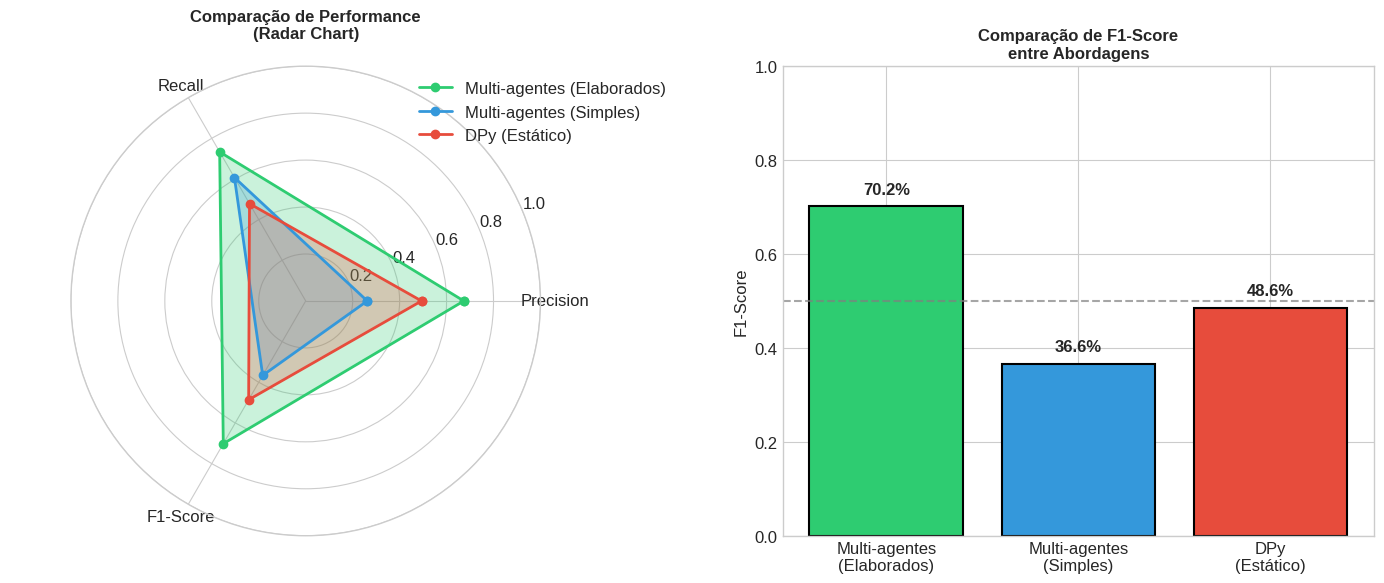

In [27]:
# Gráfico RQ3: Comparação das 3 Abordagens
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Radar Chart de Comparação
from math import pi

ax1 = axes[0]
categories = ["Precision", "Recall", "F1-Score"]
N = len(categories)

# Valores
values_ma = [
    metrics_complete["Precision"],
    metrics_complete["Recall"],
    metrics_complete["F1-Score"],
]
values_simple = [
    metrics_simple["Precision"],
    metrics_simple["Recall"],
    metrics_simple["F1-Score"],
]
values_dpy = [metrics_dpy["Precision"], metrics_dpy["Recall"], metrics_dpy["F1-Score"]]

# Preparar para radar (polar)
ax1_polar = fig.add_subplot(121, polar=True)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

values_ma += values_ma[:1]
values_simple += values_simple[:1]
values_dpy += values_dpy[:1]

ax1_polar.plot(
    angles,
    values_ma,
    "o-",
    linewidth=2,
    label="Multi-agentes (Elaborados)",
    color="#2ecc71",
)
ax1_polar.fill(angles, values_ma, alpha=0.25, color="#2ecc71")
ax1_polar.plot(
    angles,
    values_simple,
    "o-",
    linewidth=2,
    label="Multi-agentes (Simples)",
    color="#3498db",
)
ax1_polar.fill(angles, values_simple, alpha=0.25, color="#3498db")
ax1_polar.plot(
    angles, values_dpy, "o-", linewidth=2, label="DPy (Estático)", color="#e74c3c"
)
ax1_polar.fill(angles, values_dpy, alpha=0.25, color="#e74c3c")

ax1_polar.set_xticks(angles[:-1])
ax1_polar.set_xticklabels(categories)
ax1_polar.set_ylim(0, 1)
ax1_polar.set_title(
    "Comparação de Performance\n(Radar Chart)", fontsize=12, fontweight="bold", pad=20
)
ax1_polar.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))

axes[0].axis("off")  # Esconder o subplot original

# Gráfico 2: Barras agrupadas F1-Score
ax2 = axes[1]
abordagens = [
    "Multi-agentes\n(Elaborados)",
    "Multi-agentes\n(Simples)",
    "DPy\n(Estático)",
]
f1_scores = [
    metrics_complete["F1-Score"],
    metrics_simple["F1-Score"],
    metrics_dpy["F1-Score"],
]
colors = ["#2ecc71", "#3498db", "#e74c3c"]

bars = ax2.bar(abordagens, f1_scores, color=colors, edgecolor="black", linewidth=1.5)
ax2.set_ylabel("F1-Score")
ax2.set_ylim(0, 1)
ax2.set_title(
    "Comparação de F1-Score\nentre Abordagens", fontsize=12, fontweight="bold"
)
ax2.axhline(y=0.5, color="gray", linestyle="--", alpha=0.7, label="Baseline 50%")

# Adicionar valores
for bar, val in zip(bars, f1_scores):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.1%}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "rq3_comparacao_abordagens.png", dpi=150, bbox_inches="tight"
)
plt.show()


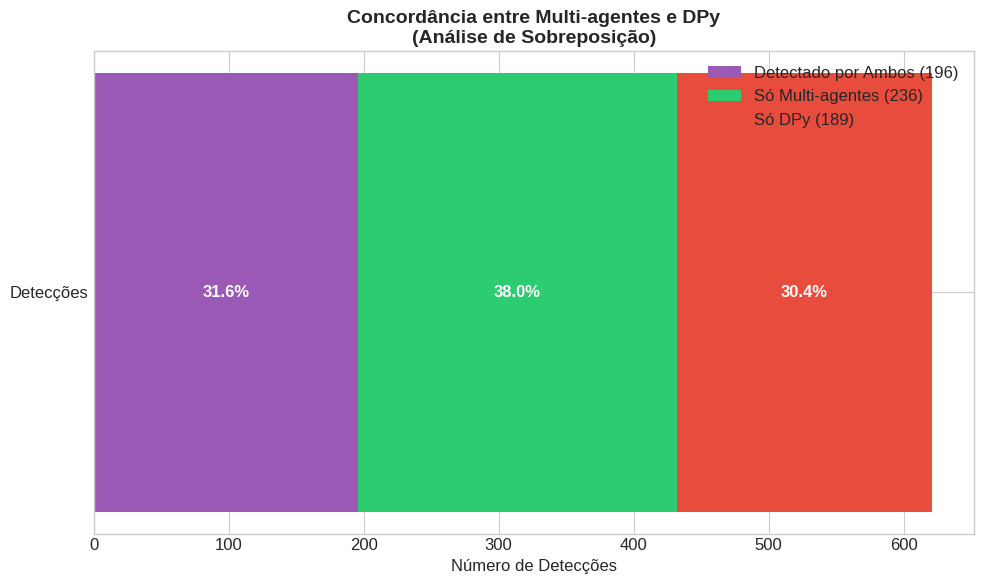

In [28]:
# Gráfico RQ3: Diagrama de Venn simplificado (Concordância)
fig, ax = plt.subplots(figsize=(10, 6))

# Criar gráfico de barras empilhadas para mostrar concordância
categories = ["Detecções"]
bar_width = 0.5

# Dados
comum_val = common
so_ma_val = only_ma
so_dpy_val = only_dpy

# Barras empilhadas horizontais
bars1 = ax.barh(
    categories,
    [comum_val],
    bar_width,
    label=f"Detectado por Ambos ({comum_val})",
    color="#9b59b6",
)
bars2 = ax.barh(
    categories,
    [so_ma_val],
    bar_width,
    left=[comum_val],
    label=f"Só Multi-agentes ({so_ma_val})",
    color="#2ecc71",
)
bars3 = ax.barh(
    categories,
    [so_dpy_val],
    bar_width,
    left=[comum_val + so_ma_val],
    label=f"Só DPy ({so_dpy_val})",
    color="#e74c3c",
)

ax.set_xlabel("Número de Detecções")
ax.set_title(
    "Concordância entre Multi-agentes e DPy\n(Análise de Sobreposição)",
    fontsize=14,
    fontweight="bold",
)
ax.legend(loc="upper right")

# Adicionar texto de porcentagem
total_det = comum_val + so_ma_val + so_dpy_val
ax.text(
    comum_val / 2,
    0,
    f"{comum_val / total_det:.1%}",
    ha="center",
    va="center",
    fontsize=12,
    color="white",
    fontweight="bold",
)
ax.text(
    comum_val + so_ma_val / 2,
    0,
    f"{so_ma_val / total_det:.1%}",
    ha="center",
    va="center",
    fontsize=12,
    color="white",
    fontweight="bold",
)
ax.text(
    comum_val + so_ma_val + so_dpy_val / 2,
    0,
    f"{so_dpy_val / total_det:.1%}",
    ha="center",
    va="center",
    fontsize=12,
    color="white",
    fontweight="bold",
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "rq3_concordancia.png", dpi=150, bbox_inches="tight")
plt.show()


---
# 5. RQ4: Performance Individual dos Agentes

**Pergunta:** Qual é a performance individual de cada agente especializado?


In [29]:
# RQ4 - Performance Individual dos Agentes
agent_performance = []

for smell in gt["smell_normalized"].unique():
    det = ma_complete[ma_complete["smell_normalized"] == smell]
    gt_smell = gt[gt["smell_normalized"] == smell]

    if len(gt_smell) == 0:
        continue

    metrics = calculate_metrics(det, gt_smell)

    agent_performance.append(
        {
            "Agente": smell.replace(" ", "_") + "_agent",
            "Smell": smell.title(),
            "GT": len(gt_smell),
            "Detectados": len(det),
            "TP": metrics["TP"],
            "FP": metrics["FP"],
            "Precision": metrics["Precision"],
            "Recall": metrics["Recall"],
            "F1-Score": metrics["F1-Score"],
        }
    )

agent_df = pd.DataFrame(agent_performance).sort_values("F1-Score", ascending=False)

# Formatar para exibição
agent_display = agent_df.copy()
agent_display["Precision"] = agent_display["Precision"].apply(lambda x: f"{x:.1%}")
agent_display["Recall"] = agent_display["Recall"].apply(lambda x: f"{x:.1%}")
agent_display["F1-Score"] = agent_display["F1-Score"].apply(lambda x: f"{x:.1%}")

print("🤖 RQ4: Performance Individual dos Agentes")
display(agent_display)


🤖 RQ4: Performance Individual dos Agentes


,Agente,Smell,GT,Detectados,TP,FP,Precision,Recall,F1-Score
9,missing_default_agent,Missing Default,1,1,1,0,100.0%,100.0%,100.0%
3,long_lambda_function_agent,Long Lambda Function,43,42,42,0,100.0%,97.7%,98.8%
1,complex_method_agent,Complex Method,53,48,48,0,100.0%,90.6%,95.0%
5,long_method_agent,Long Method,40,36,32,4,88.9%,80.0%,84.2%
10,empty_catch_block_agent,Empty Catch Block,19,17,15,2,88.2%,78.9%,83.3%
6,long_parameter_list_agent,Long Parameter List,12,19,12,7,63.2%,100.0%,77.4%
2,long_identifier_agent,Long Identifier,35,50,29,21,58.0%,82.9%,68.2%
7,long_statement_agent,Long Statement,79,74,44,30,59.5%,55.7%,57.5%
4,long_message_chain_agent,Long Message Chain,38,53,25,28,47.2%,65.8%,54.9%
8,magic_number_agent,Magic Number,71,79,41,38,51.9%,57.7%,54.7%


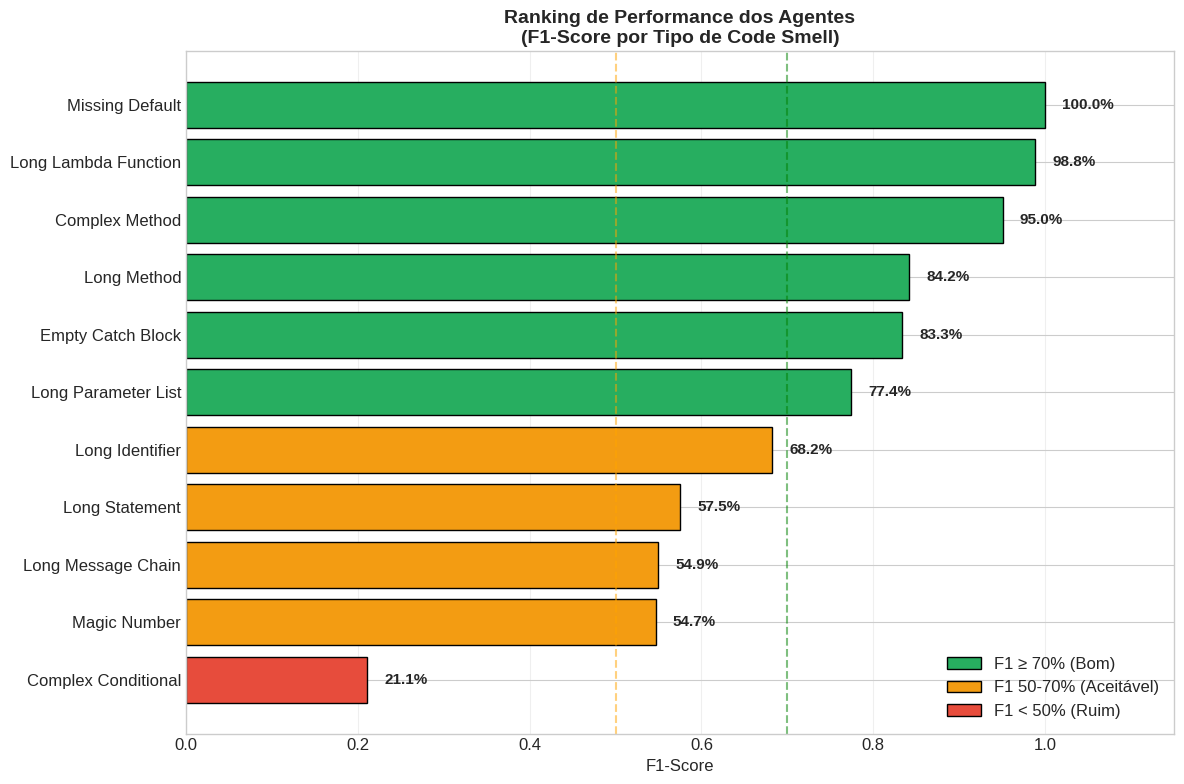

In [30]:
# Gráfico RQ4: Ranking dos Agentes por F1-Score
fig, ax = plt.subplots(figsize=(12, 8))

# Ordenar por F1-Score
agent_sorted = agent_df.sort_values("F1-Score", ascending=True)


# Cores baseadas no F1-Score
def get_color(f1):
    if f1 >= 0.7:
        return "#27ae60"  # Verde - Bom
    elif f1 >= 0.5:
        return "#f39c12"  # Amarelo - Aceitável
    else:
        return "#e74c3c"  # Vermelho - Ruim


colors = [get_color(f1) for f1 in agent_sorted["F1-Score"]]

# Criar barras horizontais
bars = ax.barh(
    agent_sorted["Smell"],
    agent_sorted["F1-Score"],
    color=colors,
    edgecolor="black",
    linewidth=1,
)

# Adicionar valores nas barras
for bar, f1 in zip(bars, agent_sorted["F1-Score"]):
    ax.text(
        bar.get_width() + 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"{f1:.1%}",
        va="center",
        fontsize=11,
        fontweight="bold",
    )

ax.set_xlabel("F1-Score", fontsize=12)
ax.set_xlim(0, 1.15)
ax.set_title(
    "Ranking de Performance dos Agentes\n(F1-Score por Tipo de Code Smell)",
    fontsize=14,
    fontweight="bold",
)

# Linhas de referência
ax.axvline(x=0.7, color="green", linestyle="--", alpha=0.5, label="Bom (≥70%)")
ax.axvline(x=0.5, color="orange", linestyle="--", alpha=0.5, label="Aceitável (≥50%)")

# Legenda para as cores
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#27ae60", edgecolor="black", label="F1 ≥ 70% (Bom)"),
    Patch(facecolor="#f39c12", edgecolor="black", label="F1 50-70% (Aceitável)"),
    Patch(facecolor="#e74c3c", edgecolor="black", label="F1 < 50% (Ruim)"),
]
ax.legend(handles=legend_elements, loc="lower right")

ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "rq4_ranking_agentes.png", dpi=150, bbox_inches="tight"
)
plt.show()


---
# 6. RQ5: Eficiência Operacional

**Pergunta:** Qual é o custo-benefício do sistema multi-agentes em termos de tempo e recursos?

**Modelo:** Claude Sonnet 4.5
- Input: $3.00/M tokens
- Output: $15.00/M tokens


In [31]:
# RQ5 - Análise de Custos Claude Sonnet 4.5
try:
    with open(RESULTS_DIR / "json" / "token_usage_complete_prompts.json") as f:
        token_data = json.load(f)

    prompt_tokens = token_data.get("token_usage", {}).get("prompt_tokens", 0)
    completion_tokens = token_data.get("token_usage", {}).get("completion_tokens", 0)
    total_tokens = token_data.get("token_usage", {}).get("total_tokens", 0)
except:
    # Estimativa se arquivo não existir
    prompt_tokens = 1_200_000
    completion_tokens = 150_000
    total_tokens = 1_350_000

# Calcular custos com Claude Sonnet 4.5
input_cost = (prompt_tokens / 1_000_000) * INPUT_PRICE_PER_M
output_cost = (completion_tokens / 1_000_000) * OUTPUT_PRICE_PER_M
total_cost = input_cost + output_cost

# Métricas de custo-benefício
cost_per_detection = total_cost / len(ma_complete) if len(ma_complete) > 0 else 0
cost_per_tp = total_cost / metrics_complete["TP"] if metrics_complete["TP"] > 0 else 0
cost_per_file = total_cost / ma_complete["file_name"].nunique()

print("💰 RQ5: Análise de Custos - Claude Sonnet 4.5")
print("=" * 60)
print(f"\n📊 Tokens Utilizados:")
print(f"   Input tokens: {prompt_tokens:,}")
print(f"   Output tokens: {completion_tokens:,}")
print(f"   Total tokens: {total_tokens:,}")
print(f"\n💵 Custos:")
print(f"   Input: ${input_cost:.4f} (${INPUT_PRICE_PER_M}/M tokens)")
print(f"   Output: ${output_cost:.4f} (${OUTPUT_PRICE_PER_M}/M tokens)")
print(f"   TOTAL: ${total_cost:.4f}")
print(f"\n📈 Métricas de Custo-Benefício:")
print(f"   Custo por arquivo: ${cost_per_file:.4f}")
print(f"   Custo por detecção: ${cost_per_detection:.6f}")
print(f"   Custo por True Positive: ${cost_per_tp:.6f}")


💰 RQ5: Análise de Custos - Claude Sonnet 4.5

📊 Tokens Utilizados:
   Input tokens: 1,655,807
   Output tokens: 55,006
   Total tokens: 1,710,813

💵 Custos:
   Input: $4.9674 ($3.0/M tokens)
   Output: $0.8251 ($15.0/M tokens)
   TOTAL: $5.7925

📈 Métricas de Custo-Benefício:
   Custo por arquivo: $0.3218
   Custo por detecção: $0.013409
   Custo por True Positive: $0.019906


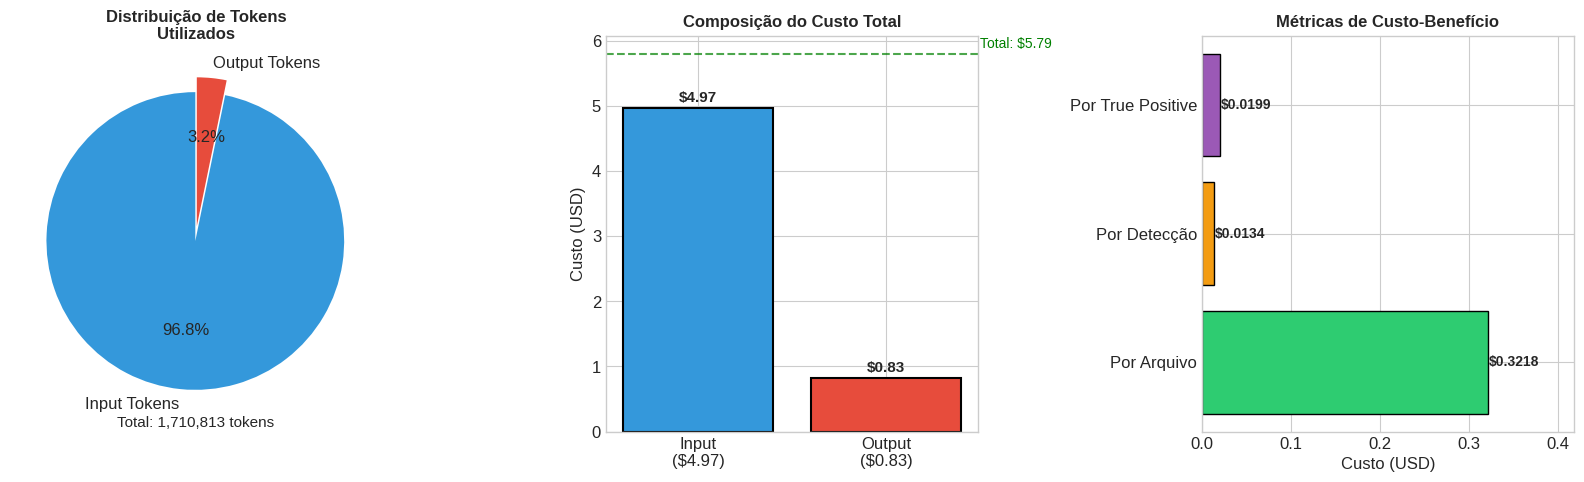

In [32]:
# Gráfico RQ5: Análise de Custos
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: Breakdown de Tokens
ax1 = axes[0]
token_labels = ["Input Tokens", "Output Tokens"]
token_values = [prompt_tokens, completion_tokens]
colors_tokens = ["#3498db", "#e74c3c"]
explode = (0.05, 0.05)

wedges, texts, autotexts = ax1.pie(
    token_values,
    labels=token_labels,
    autopct="%1.1f%%",
    colors=colors_tokens,
    explode=explode,
    startangle=90,
)
ax1.set_title("Distribuição de Tokens\nUtilizados", fontsize=12, fontweight="bold")

# Adicionar valores absolutos
ax1.text(0, -1.3, f"Total: {total_tokens:,} tokens", ha="center", fontsize=11)

# Gráfico 2: Breakdown de Custos
ax2 = axes[1]
cost_labels = [f"Input\n(${input_cost:.2f})", f"Output\n(${output_cost:.2f})"]
cost_values = [input_cost, output_cost]

bars = ax2.bar(
    cost_labels, cost_values, color=colors_tokens, edgecolor="black", linewidth=1.5
)
ax2.set_ylabel("Custo (USD)")
ax2.set_title("Composição do Custo Total", fontsize=12, fontweight="bold")

for bar, val in zip(bars, cost_values):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05,
        f"${val:.2f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Linha com custo total
ax2.axhline(y=total_cost, color="green", linestyle="--", alpha=0.7)
ax2.text(1.5, total_cost + 0.1, f"Total: ${total_cost:.2f}", fontsize=10, color="green")

# Gráfico 3: Custo-Benefício
ax3 = axes[2]
metrics_cost = ["Por Arquivo", "Por Detecção", "Por True Positive"]
costs = [cost_per_file, cost_per_detection, cost_per_tp]

bars3 = ax3.barh(
    metrics_cost, costs, color=["#2ecc71", "#f39c12", "#9b59b6"], edgecolor="black"
)
ax3.set_xlabel("Custo (USD)")
ax3.set_title("Métricas de Custo-Benefício", fontsize=12, fontweight="bold")

for bar, val in zip(bars3, costs):
    ax3.text(
        bar.get_width() + 0.001,
        bar.get_y() + bar.get_height() / 2,
        f"${val:.4f}",
        va="center",
        fontsize=10,
        fontweight="bold",
    )

ax3.set_xlim(0, max(costs) * 1.3)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "rq5_analise_custos.png", dpi=150, bbox_inches="tight"
)
plt.show()


---
# 7. Resumo Executivo


In [33]:
print("=" * 80)
print("📋 RESUMO EXECUTIVO - ANÁLISE DE RESEARCH QUESTIONS")
print("=" * 80)

print(f"""
🎯 RQ1: Performance Geral
   • F1-Score (Elaborados): {metrics_complete["F1-Score"]:.2%}
   • Precision: {metrics_complete["Precision"]:.2%} | Recall: {metrics_complete["Recall"]:.2%}
   • O sistema detecta {metrics_complete["TP"]} dos {len(gt)} smells corretamente

📝 RQ2: Impacto dos Prompts
   • Prompts Elaborados: F1 = {metrics_complete["F1-Score"]:.2%}
   • Prompts Simples: F1 = {metrics_simple["F1-Score"]:.2%}
   • Diferença: {(metrics_complete["F1-Score"] - metrics_simple["F1-Score"]) * 100:+.1f} pontos percentuais

🔄 RQ3: Multi-agentes vs DPy
   • Multi-agentes F1: {metrics_complete["F1-Score"]:.2%}
   • DPy F1: {metrics_dpy["F1-Score"]:.2%}
   • Taxa de Concordância: {agreement_rate:.1f}%

🤖 RQ4: Performance dos Agentes
   • Melhor agente: {agent_df.iloc[0]["Smell"]} (F1: {agent_df.iloc[0]["F1-Score"]:.2%})
   • Pior agente: {agent_df.iloc[-1]["Smell"]} (F1: {agent_df.iloc[-1]["F1-Score"]:.2%})
   • Agentes com F1 > 50%: {len(agent_df[agent_df["F1-Score"] > 0.5])}/{len(agent_df)}

💰 RQ5: Eficiência Operacional (Claude Sonnet 4.5)
   • Custo total: ${total_cost:.4f}
   • Custo por TP: ${cost_per_tp:.6f}
   • Tokens utilizados: {total_tokens:,}
""")

print("=" * 80)


📋 RESUMO EXECUTIVO - ANÁLISE DE RESEARCH QUESTIONS

🎯 RQ1: Performance Geral
   • F1-Score (Elaborados): 70.21%
   • Precision: 67.36% | Recall: 73.30%
   • O sistema detecta 291 dos 397 smells corretamente

📝 RQ2: Impacto dos Prompts
   • Prompts Elaborados: F1 = 70.21%
   • Prompts Simples: F1 = 36.63%
   • Diferença: +33.6 pontos percentuais

🔄 RQ3: Multi-agentes vs DPy
   • Multi-agentes F1: 70.21%
   • DPy F1: 48.59%
   • Taxa de Concordância: 31.6%

🤖 RQ4: Performance dos Agentes
   • Melhor agente: Missing Default (F1: 100.00%)
   • Pior agente: Complex Conditional (F1: 21.05%)
   • Agentes com F1 > 50%: 10/11

💰 RQ5: Eficiência Operacional (Claude Sonnet 4.5)
   • Custo total: $5.7925
   • Custo por TP: $0.019906
   • Tokens utilizados: 1,710,813



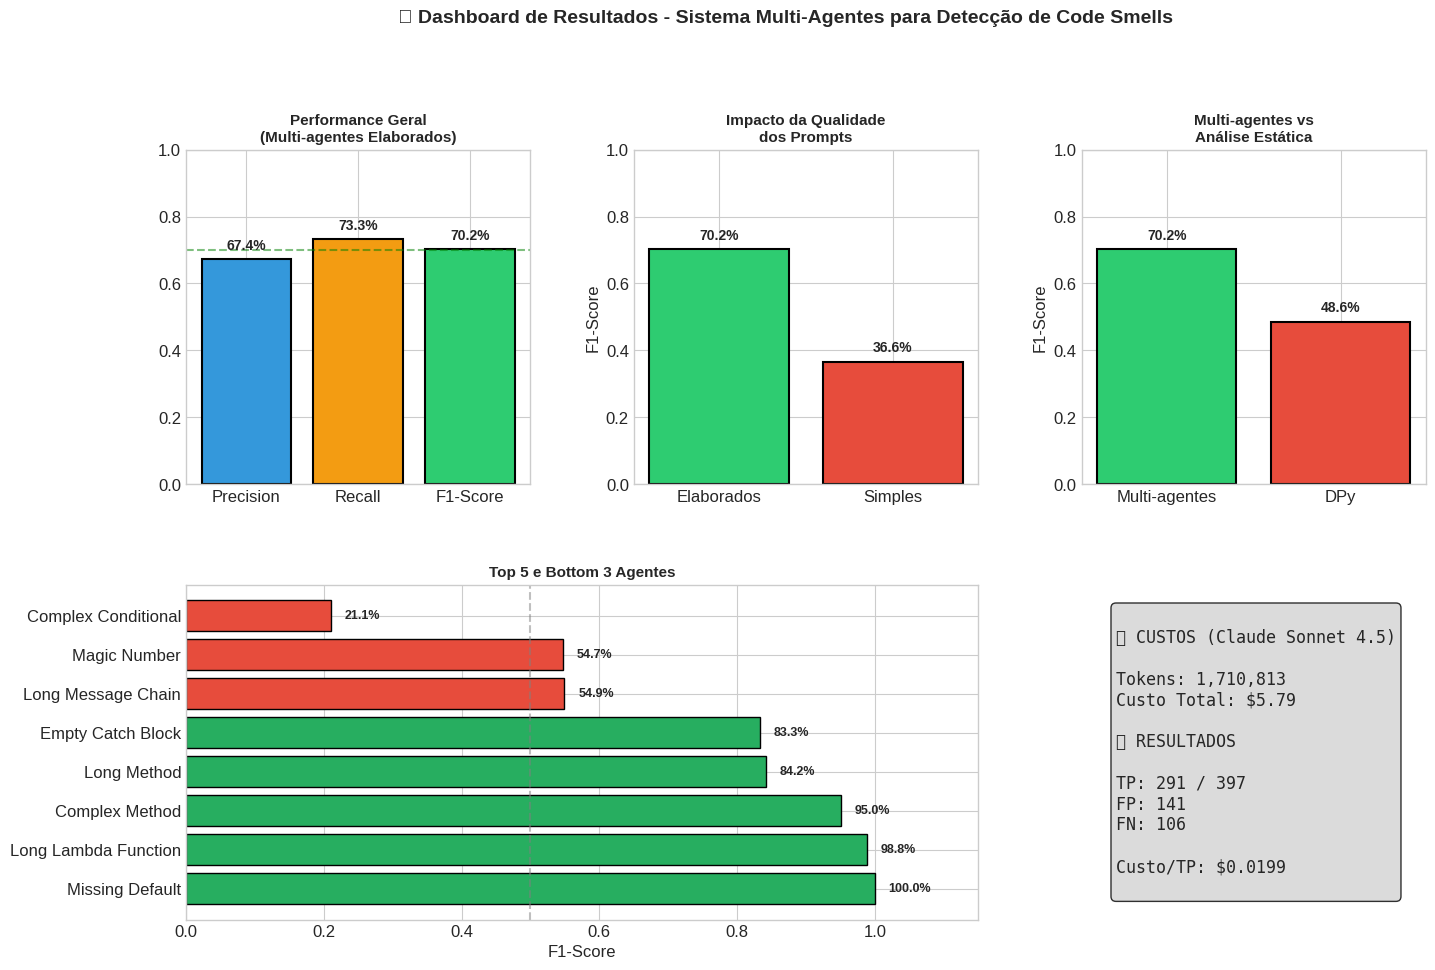

In [34]:
# Gráfico Final: Dashboard de Resumo
fig = plt.figure(figsize=(16, 10))

# Criar grid de subplots
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Métricas Principais (grande)
ax1 = fig.add_subplot(gs[0, 0])
metrics_main = ["Precision", "Recall", "F1-Score"]
values_main = [
    metrics_complete["Precision"],
    metrics_complete["Recall"],
    metrics_complete["F1-Score"],
]
colors_main = ["#3498db", "#f39c12", "#2ecc71"]
bars1 = ax1.bar(
    metrics_main, values_main, color=colors_main, edgecolor="black", linewidth=1.5
)
ax1.set_ylim(0, 1)
ax1.set_title(
    "Performance Geral\n(Multi-agentes Elaborados)", fontsize=11, fontweight="bold"
)
for bar, val in zip(bars1, values_main):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.1%}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )
ax1.axhline(y=0.7, color="green", linestyle="--", alpha=0.5)

# 2. Comparação Prompts
ax2 = fig.add_subplot(gs[0, 1])
prompts = ["Elaborados", "Simples"]
f1_prompts = [metrics_complete["F1-Score"], metrics_simple["F1-Score"]]
colors_p = ["#2ecc71", "#e74c3c"]
bars2 = ax2.bar(prompts, f1_prompts, color=colors_p, edgecolor="black", linewidth=1.5)
ax2.set_ylim(0, 1)
ax2.set_ylabel("F1-Score")
ax2.set_title("Impacto da Qualidade\ndos Prompts", fontsize=11, fontweight="bold")
for bar, val in zip(bars2, f1_prompts):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.1%}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# 3. vs DPy
ax3 = fig.add_subplot(gs[0, 2])
tools = ["Multi-agentes", "DPy"]
f1_tools = [metrics_complete["F1-Score"], metrics_dpy["F1-Score"]]
colors_t = ["#2ecc71", "#e74c3c"]
bars3 = ax3.bar(tools, f1_tools, color=colors_t, edgecolor="black", linewidth=1.5)
ax3.set_ylim(0, 1)
ax3.set_ylabel("F1-Score")
ax3.set_title("Multi-agentes vs\nAnálise Estática", fontsize=11, fontweight="bold")
for bar, val in zip(bars3, f1_tools):
    ax3.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.1%}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# 4. Top 5 e Bottom 3 Agentes
ax4 = fig.add_subplot(gs[1, :2])
# Top 5 e Bottom 3
top_agents = agent_df.head(5)
bottom_agents = agent_df.tail(3)
all_agents = pd.concat([top_agents, bottom_agents])

colors_agents = ["#27ae60"] * 5 + ["#e74c3c"] * 3
bars4 = ax4.barh(
    range(len(all_agents)),
    all_agents["F1-Score"],
    color=colors_agents,
    edgecolor="black",
)
ax4.set_yticks(range(len(all_agents)))
ax4.set_yticklabels(all_agents["Smell"])
ax4.set_xlabel("F1-Score")
ax4.set_xlim(0, 1.15)
ax4.set_title("Top 5 e Bottom 3 Agentes", fontsize=11, fontweight="bold")
ax4.axvline(x=0.5, color="gray", linestyle="--", alpha=0.5)

for bar, f1 in zip(bars4, all_agents["F1-Score"]):
    ax4.text(
        bar.get_width() + 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"{f1:.1%}",
        va="center",
        fontsize=9,
        fontweight="bold",
    )

# 5. Resumo de Custos
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis("off")
summary_text = f"""
💰 CUSTOS (Claude Sonnet 4.5)

Tokens: {total_tokens:,}
Custo Total: ${total_cost:.2f}

📊 RESULTADOS

TP: {metrics_complete["TP"]} / {len(gt)}
FP: {metrics_complete["FP"]}
FN: {metrics_complete["FN"]}

Custo/TP: ${cost_per_tp:.4f}
"""
ax5.text(
    0.1,
    0.5,
    summary_text,
    transform=ax5.transAxes,
    fontsize=12,
    verticalalignment="center",
    fontfamily="monospace",
    bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8),
)

fig.suptitle(
    "📊 Dashboard de Resultados - Sistema Multi-Agentes para Detecção de Code Smells",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "dashboard_resumo.png", dpi=150, bbox_inches="tight")
plt.show()
